In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load
from glob import glob
from sklearn.metrics import classification_report

In [2]:
matrix = "bcsstk18"
df = pd.read_csv(f"data/{matrix}_1000_testing.csv")
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,slowdown
0,bcsstk18.mat,432,0.000001,43200,4576,327,32018,9.999206e-07,True,11.864034,1.329872e+09,74.115741
1,bcsstk18.mat,432,0.000001,43200,3164,50,3454,9.960503e-07,True,1.277005,2.507101e+08,7.995370
2,bcsstk18.mat,432,0.000001,43200,4408,26,4229,9.995186e-07,True,1.603935,4.044277e+08,9.789352
3,bcsstk18.mat,432,0.000001,43200,5212,389,741,9.997350e-07,True,0.289718,1.286649e+06,1.715278
4,bcsstk18.mat,432,0.000001,43200,2973,160,1244,9.795615e-07,True,0.487112,2.538304e+07,2.879630


In [3]:
df.sort_values("slowdown", inplace=False, ascending=False).head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,slowdown
674,bcsstk18.mat,432,0.000001,43200,10039,291,43199,0.000017,False,15.367940,1.644453e+10,99.997685
148,bcsstk18.mat,432,0.000001,43200,8360,173,43199,0.000012,False,15.993103,1.993069e+09,99.997685
618,bcsstk18.mat,432,0.000001,43200,10305,359,43199,0.000013,False,15.430149,2.846133e+09,99.997685
609,bcsstk18.mat,432,0.000001,43200,1457,258,43199,0.000025,False,15.955498,5.906849e+08,99.997685
606,bcsstk18.mat,432,0.000001,43200,11698,346,43199,0.000013,False,15.658587,2.881182e+09,99.997685


In [4]:
X_test = df[["error_iter", "pos_2norm"]].to_numpy()
y_test = df["slowdown"].to_numpy()

In [5]:
p = 1 / 98
1 + (1 / p)

# 1 + (1 / x) = 99
# (1 / x) = 98
# x = 1 / 98

99.00000000000001

In [6]:
models = [load(fn) for fn in glob(f"./models/{matrix}/*.pkl")]
model_names = [model.steps[-1][1].__class__.__name__ for model in models]
ps = list(np.arange(1 / 98, 1, 0.01))

reports = pd.DataFrame(index=ps, columns=model_names)
reports.head()

,Ridge,LinearSVR,KNeighborsRegressor,RandomForestRegressor,XGBRegressor
0.010204,NaN,NaN,NaN,NaN,NaN
0.020204,NaN,NaN,NaN,NaN,NaN
0.030204,NaN,NaN,NaN,NaN,NaN
0.040204,NaN,NaN,NaN,NaN,NaN
0.050204,NaN,NaN,NaN,NaN,NaN


In [7]:
for p in ps:
    for model, name in zip(models, model_names):
        preds = model.predict(X_test)
        y_pred_clas = preds > (1 + (1 / p))
        y_true_clas = y_test > (1 + (1 / p))
        reports.loc[p][name] = classification_report(y_true_clas, y_pred_clas, 
                                                     zero_division=0, output_dict=True)

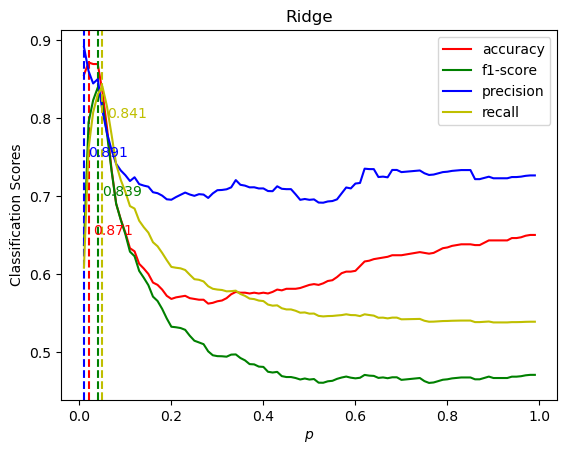

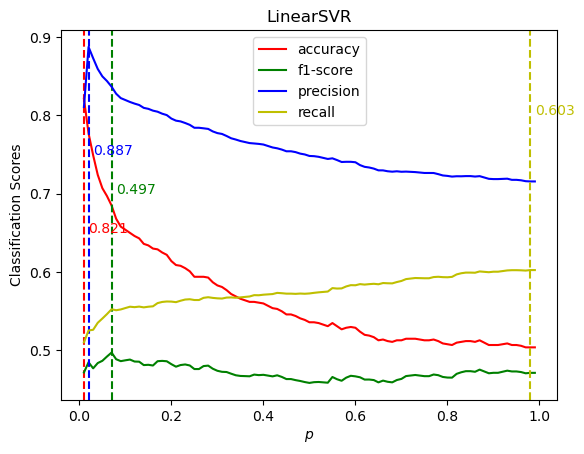

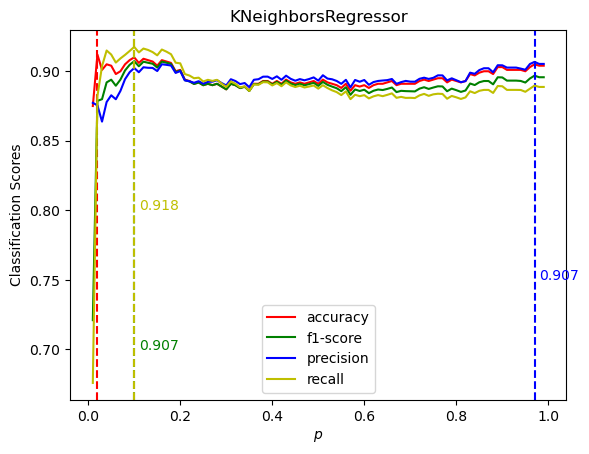

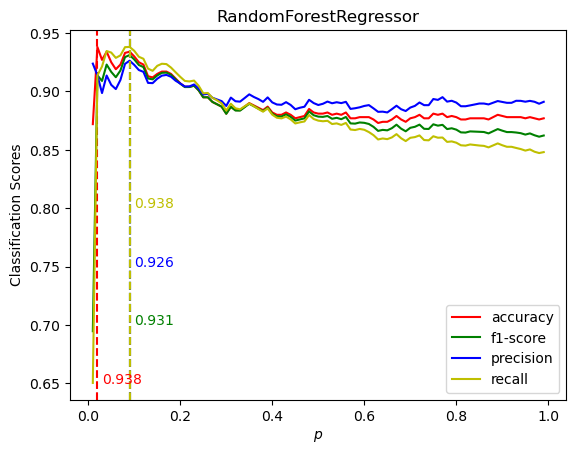

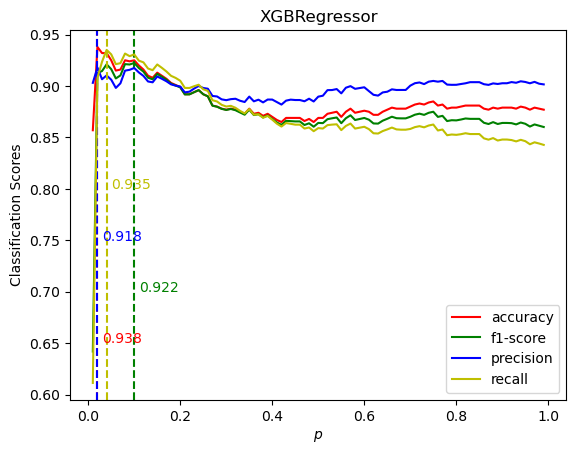

In [8]:
for name, series in reports.items():
    accuracies = [item["accuracy"] for item in series]
    best_acc_p = ps[np.argmax(accuracies)]
    scores = [item["macro avg"] for item in series]
    f1_scores = [score["f1-score"] for score in scores]
    best_f1_p = ps[np.argmax(f1_scores)]
    precisions = [score["precision"] for score in scores]
    best_precision_p = ps[np.argmax(precisions)]
    recalls = [score["recall"] for score in scores]
    best_recall_p = ps[np.argmax(recalls)]

    plt.plot(ps, accuracies, label=f"accuracy", c="r")
    plt.axvline(x=best_acc_p, linestyle='--', c="r")
    plt.annotate(f"{round(np.max(accuracies), 3)}", xy=(best_acc_p + 0.01, 0.65), c="r")

    plt.plot(ps, f1_scores, label=f"f1-score", c="g")
    plt.axvline(x=best_f1_p, linestyle='--', c="g")
    plt.annotate(f"{round(np.max(f1_scores), 3)}", xy=(best_f1_p + 0.01, 0.7), c="g")

    plt.plot(ps, precisions, label=f"precision", c="b")
    plt.axvline(x=best_precision_p, linestyle='--', c="b")
    plt.annotate(f"{round(np.max(precisions), 3)}", xy=(best_precision_p + 0.01, 0.75), c="b")

    plt.plot(ps, recalls, label=f"recall", c="y")
    plt.axvline(x=best_recall_p, linestyle='--', c="y")
    plt.annotate(f"{round(np.max(recalls), 3)}", xy=(best_recall_p + 0.01, 0.8), c="y")

    plt.title(name)
    plt.xlabel("$p$")
    plt.ylabel("Classification Scores")
    plt.legend()
    os.makedirs(f"./figures/{matrix}", exist_ok=True)
    plt.savefig(f"./figures/{matrix}/{name}.png")
    plt.show()